In [2]:
'''
This script is demo for one-one corresponding dataset with
CCA-zoo implemented MCCA, to estimate the PI
'''
import numpy as np
import matplotlib.pyplot as plt

In [1]:
'''
This part is essential to test the Python and MATLAB callability.
To apply the fmincon function in MATLAB to solve the minimization problem.
'''
import matlab
import matlab.engine

########################
mat_eng = matlab.engine.start_matlab()

In [162]:
# generate the Synthetic data from matlab
n = 100
d = 5
dx = 10
dy = 15

X, Y_init, Sx, Sy, S  = mat_eng.gen_cca_data(n, d, dx, dy, nargout=5)

print("# the dimension of X is : ", np.array(X).shape)
print("# the dimension of Y is : ", np.array(Y_init).shape)
print("# the dimension of Sx is : ")
print(np.array(Sx).shape)
print("# the dimension of Sy is : ")
print(np.array(Sy).shape)
print("# the dimension of S is : ")
print(np.array(S).shape)

# the dimension of X is :  (100, 10)
# the dimension of Y is :  (100, 15)
# the dimension of Sx is : 
(100, 10)
# the dimension of Sy is : 
(100, 10)
# the dimension of S is : 
(100, 5)


In [163]:
###########################################
#      Generate the synthetic dataset     #
###########################################
import random

# randomize the order of data samples in Y
Y_order = np.array(random.sample(range(n), n))
# re-ordered dataset Y
Y = np.zeros((np.array(Y_init).shape[0], np.array(Y_init).shape[1]))

true_PI = np.zeros((n, n))
for i in range(len(Y_order)):
    Y_i = int(Y_order[i])
    Y[i] = np.array(Y_init)[Y_i]
    # generate the groundtruth PI
    true_PI[i][Y_i] = 1

# reshape the X, Y datasets and permutation matrix
X = np.array(X).T
Y = Y.T
true_PI = true_PI

print(X.shape)
print(Y.shape)
print(true_PI.shape)

(10, 100)
(15, 100)
(100, 100)


In [2]:
#################################
#    Function for MAXVAR MCCA   #
#################################

from cca_zoo.utils.check_values import _process_parameter
from heapq import nlargest

def MAXVAR_MCCA(X, Y, PI):
    '''
    update the projections by Max-of-Variance MCCA
    input: X --> the first dataset
           Y --> the second dataset
           PI --> the estimated permutation matrix
    Output: U --> the projection matrix for dataset X
            V --> the projection matrix for dataset Y
            S --> the common resource matrix
    '''
    # common termed to be used
    YPI = np.dot(Y, PI)
    XXT_inv = np.linalg.inv(np.dot(X, X.T))
    YPI_YPIT_inv = np.linalg.inv(np.dot(YPI, YPI.T))
    
    # estimate the common resource matrix S
    f_1 = np.dot(X.T, np.dot(XXT_inv, X))
    f_2 = np.dot(YPI.T, np.dot(YPI_YPIT_inv, YPI))
    f = f_1 + f_2
    # Compute the Eigenvectors and eigenvalues for function f, as complex numbers
    eigenvalues, eigenvectors = np.linalg.eig(f)
    # only takes the real part of the complex numbers
    eigenvalues = eigenvalues.real.tolist()
    eigenvectors = eigenvectors.real
    # the first d columns of eigenvectors should be the values of S
    largest_eigen = nlargest(latent_dims, eigenvalues)
    S = []
    for principal_eigenvalue in largest_eigen:
        eigen_idx = eigenvalues.index(principal_eigenvalue)
        eigen_vec = eigenvectors[eigen_idx]
        S.append(eigen_vec)
    # convert the S matrix into array
    S = np.array(S)
    
    # estimate the projections U and V
    U = np.dot(XXT_inv, np.dot(X, S.T))
    V = np.dot(YPI_YPIT_inv, np.dot(YPI, S.T))
    
    return U, V, S

In [5]:
###################################################
#         Test the procrustes.permutation         #
#    Test with wiki_dw128 and wiki_dw200 datasets   #
###################################################

from scipy.optimize import minimize
from scipy.stats import entropy
from scipy.optimize import Bounds
import scipy
from scipy.spatial import procrustes

from pathlib import Path
# from iodata import load_one
# from iodata.utils import angstrom
# from procrustes import rotational
from procrustes import permutation

print("### Experiment of data NO index feature!! ###")
### evaluate the permutation with Wiki_embeddings, NO 
df128 = np.loadtxt('Wiki_embeddings/wiki_dw128.txt', delimiter = ' ', skiprows = 1, usecols=range(1, 129)).T
df200 = np.loadtxt('Wiki_embeddings/wiki_node200.txt', delimiter = ' ', skiprows = 1, usecols=range(1, 201)).T
print("# df16 is of size : ", df128.shape)
print(df128)
print("# df32 is of size : ", df200.shape)
print(df200)

esti_PI_NoIdx = permutation(df128, df200, pad=True)

print("# the permutation matrix is: ")
print(esti_PI_NoIdx.t)
print("# the A*P is: ")
print(np.dot(df128, esti_PI_NoIdx.t))
print("# the B is: ")
print(df200)

### Experiment of data NO index feature!! ###
# df16 is of size :  (128, 2405)
[[-2.9664550e-01 -3.0697235e-01 -1.9261949e-01 ...  1.6052672e-01
  -3.8028070e-01 -1.4412411e+00]
 [ 2.5683755e-01  5.1031332e-02  4.2876366e-01 ... -1.0390278e-01
  -7.8005143e-03 -1.0345765e+00]
 [-8.1791446e-02  1.9682011e-01 -9.1557290e-02 ...  1.8834340e-02
  -2.1594402e-01  2.4774540e+00]
 ...
 [-2.6184088e-01 -2.8352790e-01 -6.2795940e-02 ...  1.8578124e-01
  -1.5014867e-01  5.9148103e-01]
 [-1.6339578e-03 -1.3055106e-01  2.1930984e-01 ... -1.0484107e-01
   1.8645848e-01  1.8861721e-01]
 [ 1.9291838e-01  3.0451250e-01  2.6148596e-01 ...  1.4075616e-01
   4.7732893e-02 -1.4440607e-01]]
# df32 is of size :  (200, 2405)
[[ 0.4578394   0.08178811  0.3494665  ... -0.13417469  0.03728042
   0.3374032 ]
 [-0.0308581  -0.28987145  0.18906489 ...  0.19421697  0.1646674
   0.0941207 ]
 [-0.5116544  -0.1934395  -0.5688844  ...  0.03647949 -0.32220277
  -0.6591894 ]
 ...
 [ 0.09285619 -0.27203208  0.26710925 ...

In [ ]:
##########################################
### Permutation evaluation -- NO index ###
##########################################

acc = 0.0
for i in range(2405):
    esti_idx_NoIdx = np.where(esti_PI_NoIdx.t[i]==1)[0][0]
    if esti_idx_NoIdx == i:
        acc += 1
print("# Accuracy of permutation(No index) is: ", acc/2405)

# Accuracy of permutation(No index) is:  0.002494802494802495


In [128]:
###################################################
#         Test the procrustes.permutation         #
#           Test with synthetic datasets          #
###################################################

from scipy.optimize import minimize
from scipy.stats import entropy
from scipy.optimize import Bounds
import scipy
from scipy.spatial import procrustes

from pathlib import Path
# from iodata import load_one
# from iodata.utils import angstrom
# from procrustes import rotational
from procrustes import permutation
# Y = np.array(Y).reshape(Y.size, order='F')
print(Y.shape)
Y_trim = Y[:X.shape[0],:]
print("size of Y_trim: \n", Y_trim.shape)
print("size of X (for comparing Y_trim): \n", X.shape)
print("### Experiment of data NO index feature!! ###")

### Take SVD of X and Y to get their correpsonding latent representations with same dim
from scipy.linalg import svd

# Perform SVD on X and Y
Ux, Sx, VxT = svd(X, full_matrices=False)
Uy, Sy, VyT = svd(Y, full_matrices=False)

# Select the top k singular vectors/values
k = 5
X_k = Ux[:, :k] @ np.diag(Sx[:k]) @ VxT[:k, :]
Y_k = Uy[:, :k] @ np.diag(Sy[:k]) @ VyT[:k, :]

# use X_k and Y_k in permutation function
print(X_k.shape)
print(Y_k.shape)
esti_PI_NoIdx = permutation(X_k, Y_k, pad=True)

print("# the permutation matrix is: ")
print(esti_PI_NoIdx.t)
print("# the A*P is: ")
print(np.dot(X, esti_PI_NoIdx.t))
print("# the B is: ")
print(Y)

### evaluate the permutation matrix
acc = 0.0
for ii in range(3000):
    esti_idx = np.where(esti_PI_NoIdx.t[ii]==1)[0]
    if esti_idx.size > 0:
        esti_idx = esti_idx[0]
    if esti_idx == int(Y_order[i]):
        acc += 1
print("# Accuracy of iter = ", i, " is: ", acc/3000)
acc_history.append(acc)


(15, 3000)
size of Y_trim: 
 (10, 3000)
size of X (for comparing Y_trim): 
 (10, 3000)
### Experiment of data NO index feature!! ###
(10, 3000)
(15, 3000)
# the permutation matrix is: 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
# the A*P is: 
[[-20.23871445  -9.70632819 -12.70387159 ...  -2.06556392  12.29987678
   -6.0987942 ]
 [-18.62888087   3.55847263 -10.43303439 ...  -5.55233531  -0.9670678
  -10.92378945]
 [  7.84701981   3.67643472   2.64074644 ...  13.6147982   18.4185636
   12.19268228]
 ...
 [-17.48685045  -1.77925285  -9.19261735 ... -10.42041862 -16.07833079
   -9.5011256 ]
 [  1.23243919  -6.26165538  -5.84112952 ...   4.69191802   6.61059682
    4.68147972]
 [  5.41523721 -21.10624832  -4.04890221 ...  13.70901261  -4.04249624
    4.83797711]]
# the B is: 
[[ -7.48942294  -1.5696013    3.34890103 ...  -1.33648137  10.37965096
    2.60977447]
 [-16.60575424  -9

In [ ]:
###################################################
#         Test the procrustes.permutation         #
#    Test with wiki_dw16 and wiki_dw16 datasets   #
###################################################

from scipy.optimize import minimize
from scipy.stats import entropy
from scipy.optimize import Bounds
import scipy
from scipy.spatial import procrustes

from pathlib import Path
# from iodata import load_one
# from iodata.utils import angstrom
# from procrustes import rotational
from procrustes import permutation

print("### Experiment of data NO index feature!! ###")
### evaluate the permutation with Wiki_embeddings, NO 
df16_1 = np.loadtxt('Wiki_embeddings/Wiki_embeddings/wiki_dw128.txt', delimiter = ' ', skiprows = 1, usecols=range(1, 129)).T
df16_2 = np.loadtxt('Wiki_embeddings/Wiki_embeddings/wiki_dw128.txt', delimiter = ' ', skiprows = 1, usecols=range(1, 129)).T
print("# df16_1 is of size : ", df16_1.shape)
print(df16_1)
print("# df16_2 is of size : ", df16_2.shape)
print(df16_2)

esti_PI_NoIdx = permutation(df16_1, df16_2, pad=True)

print("# the permutation matrix is: ")
print(esti_PI_NoIdx.t)
print("# the A*P is: ")
print(np.dot(df16_1, esti_PI_NoIdx.t))
print("# the B is: ")
print(df16_2)

### Experiment of data NO index feature!! ###
# df16_1 is of size :  (128, 2405)
[[-2.9664550e-01 -3.0697235e-01 -1.9261949e-01 ...  1.6052672e-01
  -3.8028070e-01 -1.4412411e+00]
 [ 2.5683755e-01  5.1031332e-02  4.2876366e-01 ... -1.0390278e-01
  -7.8005143e-03 -1.0345765e+00]
 [-8.1791446e-02  1.9682011e-01 -9.1557290e-02 ...  1.8834340e-02
  -2.1594402e-01  2.4774540e+00]
 ...
 [-2.6184088e-01 -2.8352790e-01 -6.2795940e-02 ...  1.8578124e-01
  -1.5014867e-01  5.9148103e-01]
 [-1.6339578e-03 -1.3055106e-01  2.1930984e-01 ... -1.0484107e-01
   1.8645848e-01  1.8861721e-01]
 [ 1.9291838e-01  3.0451250e-01  2.6148596e-01 ...  1.4075616e-01
   4.7732893e-02 -1.4440607e-01]]
# df16_2 is of size :  (128, 2405)
[[-2.9664550e-01 -3.0697235e-01 -1.9261949e-01 ...  1.6052672e-01
  -3.8028070e-01 -1.4412411e+00]
 [ 2.5683755e-01  5.1031332e-02  4.2876366e-01 ... -1.0390278e-01
  -7.8005143e-03 -1.0345765e+00]
 [-8.1791446e-02  1.9682011e-01 -9.1557290e-02 ...  1.8834340e-02
  -2.1594402e-01  2.

In [ ]:
##########################################
### Permutation evaluation -- NO index ###
##########################################

acc = 0.0
for i in range(2405):
    esti_idx_NoIdx = np.where(esti_PI_NoIdx.t[i]==1)[0][0]
    if esti_idx_NoIdx == i:
        acc += 1
print("# Accuracy of permutation(No index) is: ", acc/2405)

# Accuracy of permutation(No index) is:  1.0


In [18]:
###################################################
#         Test the procrustes.permutation         #
#    Test with wiki_dw128 and wiki_dw128 datasets   #
#                                                 #
#        Re-Order the second wiki_dw128 dataset    #
###################################################

from scipy.optimize import minimize
from scipy.stats import entropy
from scipy.optimize import Bounds
import scipy
from scipy.spatial import procrustes

from pathlib import Path
from procrustes import permutation

import numpy as np
import random

print("### Experiment of data NO index feature!! ###")
### evaluate the permutation with Wiki_embeddings, NO 
df16_1 = np.loadtxt('Wiki_embeddings/wiki_dw128.txt', delimiter = ' ', skiprows = 1, usecols=range(1, 129)).T
df16_2 = np.loadtxt('Wiki_embeddings/wiki_dw128.txt', delimiter = ' ', skiprows = 1, usecols=range(1, 129)).T

### reorder the second dataset
reorder = np.array(random.sample(range(2405), 2405))
print("# reorder : ", reorder)
df16_2 = df16_2[:, reorder]
print("# df16_1 is of size : ", df16_1.shape)
print(df128)
print("# df16_2 is of size : ", df16_2.shape)
print(df200)

### generate the true permutatoin
true_PI = np.zeros((2405, 2405))
for i in range(2405):
    true_PI[reorder[i]][i] = 1

esti_PI_NoIdx = permutation(df16_1, df16_2, pad=True)

print("# the permutation matrix is: ")
print(esti_PI_NoIdx.t)
print("# the A*P is: ")
print(np.dot(df16_1, esti_PI_NoIdx.t))
print("# the B is: ")
print(df16_2)

### Experiment of data NO index feature!! ###
# reorder :  [2359 1146 1247 ... 1770  358  520]
# df16_1 is of size :  (128, 2405)
[[-2.9664550e-01 -3.0697235e-01 -1.9261949e-01 ...  1.6052672e-01
  -3.8028070e-01 -1.4412411e+00]
 [ 2.5683755e-01  5.1031332e-02  4.2876366e-01 ... -1.0390278e-01
  -7.8005143e-03 -1.0345765e+00]
 [-8.1791446e-02  1.9682011e-01 -9.1557290e-02 ...  1.8834340e-02
  -2.1594402e-01  2.4774540e+00]
 ...
 [-2.6184088e-01 -2.8352790e-01 -6.2795940e-02 ...  1.8578124e-01
  -1.5014867e-01  5.9148103e-01]
 [-1.6339578e-03 -1.3055106e-01  2.1930984e-01 ... -1.0484107e-01
   1.8645848e-01  1.8861721e-01]
 [ 1.9291838e-01  3.0451250e-01  2.6148596e-01 ...  1.4075616e-01
   4.7732893e-02 -1.4440607e-01]]
# df16_2 is of size :  (128, 2405)
[[ 0.4578394   0.08178811  0.3494665  ... -0.13417469  0.03728042
   0.3374032 ]
 [-0.0308581  -0.28987145  0.18906489 ...  0.19421697  0.1646674
   0.0941207 ]
 [-0.5116544  -0.1934395  -0.5688844  ...  0.03647949 -0.32220277
  -0.659

In [19]:
##########################################
### Permutation evaluation -- NO index ###
##########################################
esti_order = []
true_PI_order = []
acc = 0.0
for i in range(2405):
    esti_idx_NoIdx = np.where(esti_PI_NoIdx.t[i]==1)[0][0]
    true_idx = np.where(true_PI[i]==1)[0][0]
    esti_order.append(esti_idx_NoIdx)
    true_PI_order.append(true_idx)
    if esti_idx_NoIdx == true_idx:
        acc += 1
print("# Accuracy of permutation(No index) is: ", acc/2405)
print("# the true order is : ", np.array(true_PI_order))
print("# the estimated order is : ", np.array(esti_order))

# Accuracy of permutation(No index) is:  1.0
# the true order is :  [  84  927 2091 ... 2188  696  411]
# the estimated order is :  [  84  927 2091 ... 2188  696  411]


In [20]:
###########################################
#        Main Part of ACCA algorithm      #
###########################################
import random

### load in the dataset
X = np.loadtxt('Wiki_embeddings/wiki_dw128.txt', delimiter = ' ', \
               skiprows = 1, usecols=range(1, 129)).T
Y = np.loadtxt('Wiki_embeddings/wiki_dw200.txt', delimiter = ' ', \
               skiprows = 1, usecols=range(1, 201)).T


from heapq import nlargest
import time
import copy
from procrustes import permutation

# the total training iterations
n = 2405
train_epoch = 50
latent_dims = 8

esti_PI_history = []
acc_history = []
for i in range(train_epoch):
    ## estimate the permutation matrix
    t_PI = time.time()
    if i > 0:
        XU = np.dot(X.T, U)
        YV = np.dot(Y.T, V)
        
        esti_PI = permutation(YV.T, S.T)
        ### Compute the distance betwwen YV and S    
        distance = np.linalg.norm(YV - S, ord='fro')
        print("Distance between YV and S:", distance)
        
        esti_PI = np.array(esti_PI.t)
    else:
        # initialize the PI at totally random
        esti_PI = np.zeros((n, n))
        for j in range(int(n)):
            esti_PI[j] = np.random.dirichlet(np.ones(n),size=1)[0]
    t_PI = time.time() - t_PI
    esti_PI_history.append(esti_PI)
    
    ## estimation of the CCA part
    t_CCA = time.time()
    U, V, S = MAXVAR_MCCA(X, Y, esti_PI)
    t_CCA = time.time() - t_CCA
    
    ### evaluate the permutation matrix
    PI = esti_PI_history[i]
    acc = 0.0
    for ii in range(2405):
        esti_idx = np.where(PI[ii]==1)[0]
        if esti_idx.size > 0:
            esti_idx = esti_idx[0]
        if esti_idx == ii:
            acc += 1
    print("# Accuracy of iter = ", i, " is: ", acc/2405)
    acc_history.append(acc)


/var/folders/40/dwwt9ypj3bq7hk3cgxb8rkmr0000gn/T/ipykernel_51872/2017038523.py:54: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if esti_idx == ii:


# Accuracy of iter =  0  is:  0.0
# Accuracy of iter =  1  is:  0.9704781704781705
# Accuracy of iter =  2  is:  0.9675675675675676
# Accuracy of iter =  3  is:  0.9762993762993764
# Accuracy of iter =  4  is:  0.9746361746361747
# Accuracy of iter =  5  is:  0.9783783783783784
# Accuracy of iter =  6  is:  0.9688149688149689
# Accuracy of iter =  7  is:  0.977962577962578
# Accuracy of iter =  8  is:  0.9704781704781705
# Accuracy of iter =  9  is:  0.9733887733887734
# Accuracy of iter =  10  is:  0.9758835758835759
# Accuracy of iter =  11  is:  0.9721413721413722
# Accuracy of iter =  12  is:  0.975051975051975
# Accuracy of iter =  13  is:  0.972972972972973
# Accuracy of iter =  14  is:  0.9783783783783784
# Accuracy of iter =  15  is:  0.9696465696465697
# Accuracy of iter =  16  is:  0.9725571725571726
# Accuracy of iter =  17  is:  0.9762993762993764
# Accuracy of iter =  18  is:  0.9742203742203742
# Accuracy of iter =  19  is:  0.9708939708939709
# Accuracy of iter =  20  is

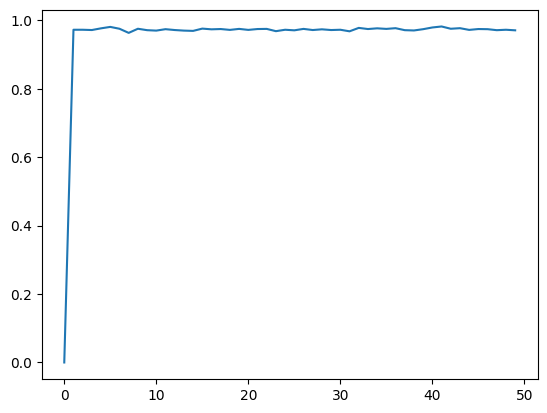

In [ ]:
plt.plot(np.array(acc_history) / 2405)

In [82]:
###########################################
#        Main Part of ACCA algorithm      #
#               10% reorder               #
###########################################
import random

### load in the dataset
X = np.loadtxt('Wiki_embeddings/wiki_dw128.txt', delimiter = ' ', \
               skiprows = 1, usecols=range(1, 129)).T
Y_origin = np.loadtxt('Wiki_embeddings/wiki_hope200.txt', delimiter = ' ', \
               skiprows = 1, usecols=range(1, 201)).T

''' reorder 10% of Y dataset '''

### Calculate the number of elements to reorder (10% of the Y dataset)
num_elements_reorder = int(0.1 * Y_origin.shape[1])
### Generate a permutation for the first 10% of the indices
reorder = np.array(random.sample(range(num_elements_reorder), num_elements_reorder))
### create array for the remaining 90% of indices
remaining_indices = np.array(range(num_elements_reorder, Y_origin.shape[1]))
### concatenate the reordered indices with the remaining indices
new_order = np.concatenate((reorder, remaining_indices))
### Apply the new order (reorder 10% of the Y dataset)
Y = Y_origin[:, new_order]
print("Size of Y: \n", Y.shape)

''' Trim Y dataset as same size as X dataset'''
# If X has fewer or the same number of columns as Y
Y_trim = Y[:X.shape[0],:]
print("size of Y_trim: \n", Y_trim.shape)
print("size of X (for comparing Y_trim): \n", X.shape)
# If X has more columns than Y --- Separate case

### generate the true permutatoin
true_PI = np.zeros((2405, 2405))
for i in range(2405):
    true_PI[i][new_order[i]]= 1


eval_true_PI = []
for i in range(2405):
    true_idx = np.where(true_PI[i]==1)[0][0]
    eval_true_PI.append(true_idx)
eval_true_PI = np.array(eval_true_PI)
print(range(2045))
print(eval_true_PI)
print("##########################")


from heapq import nlargest
import time
import copy
from procrustes import permutation

# the total training iterations
n = 2405
train_epoch = 10
latent_dims = 100

esti_PI_history = []
acc_history = []
vyps_distance = []
uxs_distance = []

for i in range(train_epoch):
    ## estimate the permutation matrix
    t_PI = time.time()
    if i > 0:
        XU = np.dot(X.T, U)
        YV = np.dot(Y.T, V)
        
        #######################################
        # Change procrustes.permutation to OT #
        #######################################
        esti_PI = optimal_permutation(YV.T, S.T)
        print(esti_PI.shape)
        ### Compute the distance betwwen YV and S    
        distance_yv = np.linalg.norm(np.dot(YV.T, esti_PI) - S, ord='fro')
        print("Distance between YV and S:", distance)
        vyps_distance.append(distance_yv)

        distance_xu = np.linalg.norm(XU.T - S, ord='fro')
        print("Distance between XU and S:", distance)
        uxs_distance.append(distance_xu)

        esti_PI = np.array(esti_PI.t)
    else:
        # initialize the PI at totally random
        esti_PI = np.zeros((n, n))
        for j in range(int(n)):
            esti_PI[j] = np.random.dirichlet(np.ones(n),size=1)[0]
        # esti_PI = permutation(X, Y_trim)
        # esti_PI = np.array(esti_PI.t)
    t_PI = time.time() - t_PI
    esti_PI_history.append(esti_PI)
    
    ## estimation of the CCA part
    t_CCA = time.time()
    U, V, S = MAXVAR_MCCA(X, Y, esti_PI)
    t_CCA = time.time() - t_CCA
    
    ### evaluate the permutation matrix
    PI = esti_PI_history[i]
    acc = 0.0
    for ii in range(2405):
        esti_idx = np.where(PI[ii]==1)[0]
        if esti_idx.size > 0:
            esti_idx = esti_idx[0]
        true_idx = np.where(true_PI[ii]==1)[0][0]
        print("# evaluate-", ii, " : ", esti_idx, " - ", true_idx, " ...")
        if esti_idx == true_idx:
            acc += 1
    print("# Accuracy of iter = ", i, " is: ", acc/2405)
    acc_history.append(acc)


Size of Y: 
 (200, 2405)
size of Y_trim: 
 (128, 2405)
size of X (for comparing Y_trim): 
 (128, 2405)
range(0, 2045)
[ 208   85   34 ... 2402 2403 2404]
##########################
# evaluate- 0  :  []  -  208  ...
# evaluate- 1  :  []  -  85  ...
# evaluate- 2  :  []  -  34  ...
# evaluate- 3  :  []  -  17  ...
# evaluate- 4  :  []  -  117  ...
# evaluate- 5  :  []  -  10  ...
# evaluate- 6  :  []  -  87  ...
# evaluate- 7  :  []  -  19  ...
# evaluate- 8  :  []  -  150  ...
# evaluate- 9  :  []  -  159  ...
# evaluate- 10  :  []  -  107  ...
# evaluate- 11  :  []  -  125  ...
# evaluate- 12  :  []  -  46  ...
# evaluate- 13  :  []  -  148  ...
# evaluate- 14  :  []  -  8  ...
# evaluate- 15  :  []  -  185  ...
# evaluate- 16  :  []  -  105  ...
# evaluate- 17  :  []  -  39  ...
# evaluate- 18  :  []  -  199  ...
# evaluate- 19  :  []  -  178  ...
# evaluate- 20  :  []  -  106  ...
# evaluate- 21  :  []  -  97  ...
# evaluate- 22  :  []  -  75  ...
# evaluate- 23  :  []  -  163  ...
#

/var/folders/40/dwwt9ypj3bq7hk3cgxb8rkmr0000gn/T/ipykernel_51872/2051228577.py:111: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if esti_idx == true_idx:


ValueError: shapes (100,2405) and (100,2405) not aligned: 2405 (dim 1) != 100 (dim 0)

In [236]:
###########################################
#        Main Part of ACCA algorithm      #
#               10% reorder               #
###########################################
import random

# ### load in the dataset
# X = np.loadtxt('Wiki_embeddings/wiki_dw128.txt', delimiter = ' ', \
#                skiprows = 1, usecols=range(1, 129)).T
# Y_origin = np.loadtxt('Wiki_embeddings/wiki_hope200.txt', delimiter = ' ', \
#                skiprows = 1, usecols=range(1, 201)).T

# ''' reorder 10% of Y dataset '''

# ### Calculate the number of elements to reorder (10% of the Y dataset)
# num_elements_reorder = int(0.5 * Y_origin.shape[1])
# ### Generate a permutation for the first 10% of the indices
# reorder = np.array(random.sample(range(num_elements_reorder), num_elements_reorder))
# ### create array for the remaining 90% of indices
# remaining_indices = np.array(range(num_elements_reorder, Y_origin.shape[1]))
# ### concatenate the reordered indices with the remaining indices
# new_order = np.concatenate((reorder, remaining_indices))
# ### Apply the new order (reorder 10% of the Y dataset)
# Y = Y_origin[:, new_order]
# print("Size of Y: \n", Y.shape)

''' Trim Y dataset as same size as X dataset'''
# If X has fewer or the same number of columns as Y
Y_trim = Y[:X.shape[0],:]
print("size of Y_trim: \n", Y_trim.shape)
print("size of X (for comparing Y_trim): \n", X.shape)
# If X has more columns than Y --- Separate case

# ### generate the true permutatoin
# true_PI = np.zeros((2405, 2405))
# for i in range(2405):
#     true_PI[i][new_order[i]]= 1


eval_true_PI = []
for i in range(100):
    true_idx = np.where(true_PI[i]==1)[0][0]
    eval_true_PI.append(true_idx)
eval_true_PI = np.array(eval_true_PI)
print(Y_order)
print(eval_true_PI)
print("##########################")


from heapq import nlargest
import time
import copy
from procrustes import permutation

# the total training iterations
n = 100
train_epoch = 40
latent_dims = 5

esti_PI_history = []
acc_history = []
yvps_distance = []
xus_distance = []
yvs_distance = []

for i in range(train_epoch):
    ## estimate the permutation matrix
    t_PI = time.time()
    if i > 0:
        XU = np.dot(X.T, U)
        YV = np.dot(Y.T, V)
        
        esti_PI = permutation(YV.T, S.T)
        ### Compute the distance betwwen YV and S    
        distance_yvps = np.linalg.norm(np.dot(YV.T, esti_PI.t) - S, ord='fro')
        print("Distance between YV and S:", distance_yvps)
        yvps_distance.append(distance_yv)

        distance_xu = np.linalg.norm(XU.T - S, ord='fro')
        print("Distance between XU and S:", distance_xu)
        xus_distance.append(distance_xu)

        distance_yvs = np.linalg.norm(YV.T - S, ord='fro')
        print("Distance between XU and S:", distance_yvs)
        yvs_distance.append(distance_yvs)

        esti_PI = np.array(esti_PI.t)
    else:
        # initialize the PI at totally random
        esti_PI = np.zeros((n, n))
        for j in range(int(n)):
            esti_PI[j] = np.random.dirichlet(np.ones(n),size=1)[0]
        # esti_PI = permutation(X, Y_trim)
        # esti_PI = np.array(esti_PI.t)
    t_PI = time.time() - t_PI
    esti_PI_history.append(esti_PI)
    
    ## estimation of the CCA part
    t_CCA = time.time()
    U, V, S = MAXVAR_MCCA(X, Y, esti_PI)
    print("size of U: \n", U.shape)
    print("size of V: \n", V.shape)
    print("size of P: \n", esti_PI.shape)
    print("size of S: \n", S.shape)
    t_CCA = time.time() - t_CCA
    
    ### evaluate the permutation matrix
    PI = esti_PI_history[i]
    acc = 0.0
    for ii in range(n):
        esti_idx = np.where(PI[ii]==1)[0]
        if esti_idx.size > 0:
            esti_idx = esti_idx[0]
        true_idx = np.where(true_PI[ii]==1)[0][0]
        print("# evaluate-", ii, " : ", esti_idx, " - ", true_idx, " ...")
        if esti_idx == true_idx:
            acc += 1
    # Check if PI * PI equals to identity matrix
    identity_matrix = np.eye(PI.shape[0])
    if np.allclose(np.dot(esti_PI, esti_PI.T), identity_matrix):
        print(f"esti_PI times esti_PI.T is equal to identity in iteration {i}")
    else:
        print(f"esti_PI times esti_PI.T is not equal to identity in iteration {i}")
    # Check if P.T * P equals to identity matrix
    if np.allclose(np.dot(esti_PI.T, esti_PI), identity_matrix):
        print(f"esti_PI.T times esti_PI is equal to identity in iteration {i}")
    else:
        print(f"esti_PI.T times esti_PI is not equal to identity in iteration {i}")
    print("# Accuracy of iter = ", i, " is: ", acc/100)
    acc_history.append(acc/100)


size of Y_trim: 
 (10, 100)
size of X (for comparing Y_trim): 
 (10, 100)
[28 52 81 95 29 96 70 78 13 61 63  8 65 73 85 59 17 62  3 77 72 90 42 60
 45 56 47 40  5 88 74 46  0 12 80 30  4 24  9 43 55 64 25 97 14 23 48 51
  2  7 10 33 98 67 38 20 91 19 82 37 83 50 15 54 94 41 75 11 86 31 84 32
 44 89 26 58 68 53 99 92 36  1 66  6 57 93 16 22 27 34 21 71 18 79 49 39
 69 35 76 87]
[28 52 81 95 29 96 70 78 13 61 63  8 65 73 85 59 17 62  3 77 72 90 42 60
 45 56 47 40  5 88 74 46  0 12 80 30  4 24  9 43 55 64 25 97 14 23 48 51
  2  7 10 33 98 67 38 20 91 19 82 37 83 50 15 54 94 41 75 11 86 31 84 32
 44 89 26 58 68 53 99 92 36  1 66  6 57 93 16 22 27 34 21 71 18 79 49 39
 69 35 76 87]
##########################
size of U: 
 (10, 5)
size of V: 
 (15, 5)
size of P: 
 (100, 100)
size of S: 
 (5, 100)
# evaluate- 0  :  []  -  28  ...
# evaluate- 1  :  []  -  52  ...
# evaluate- 2  :  []  -  81  ...
# evaluate- 3  :  []  -  95  ...
# evaluate- 4  :  []  -  29  ...
# evaluate- 5  :  []  -  96  ...
#

/var/folders/40/dwwt9ypj3bq7hk3cgxb8rkmr0000gn/T/ipykernel_51872/4081752791.py:116: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if esti_idx == true_idx:


esti_PI times esti_PI.T is equal to identity in iteration 20
esti_PI.T times esti_PI is equal to identity in iteration 20
# Accuracy of iter =  20  is:  0.0
Distance between YV and S: 1.9808642761077329
Distance between XU and S: 1.9781800393860751
Distance between XU and S: 1.9858048680702323
size of U: 
 (10, 5)
size of V: 
 (15, 5)
size of P: 
 (100, 100)
size of S: 
 (5, 100)
# evaluate- 0  :  13  -  28  ...
# evaluate- 1  :  24  -  52  ...
# evaluate- 2  :  69  -  81  ...
# evaluate- 3  :  9  -  95  ...
# evaluate- 4  :  5  -  29  ...
# evaluate- 5  :  6  -  96  ...
# evaluate- 6  :  7  -  70  ...
# evaluate- 7  :  25  -  78  ...
# evaluate- 8  :  8  -  13  ...
# evaluate- 9  :  22  -  61  ...
# evaluate- 10  :  10  -  63  ...
# evaluate- 11  :  11  -  8  ...
# evaluate- 12  :  12  -  65  ...
# evaluate- 13  :  26  -  73  ...
# evaluate- 14  :  14  -  85  ...
# evaluate- 15  :  15  -  59  ...
# evaluate- 16  :  16  -  17  ...
# evaluate- 17  :  17  -  62  ...
# evaluate- 18  :  18

PI Accuracy [0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0]
||VYP - S||F2 
 [9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289, 9.587892887026289]
||UX - S||F2 
 [1.80824

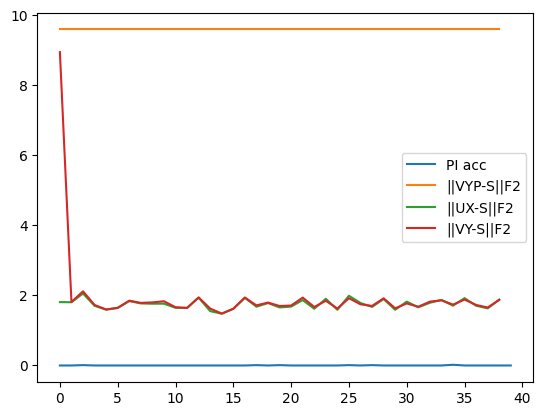

In [232]:
#####################################################
# Plot accuracy and Distance between YVP-S and XU-S #
#####################################################
import matplotlib.pyplot as plt
plt.plot(acc_history)
plt.plot(yvps_distance)
plt.plot(xus_distance)
plt.plot(yvs_distance)
plt.legend(["PI acc", "||VYP-S||F2", "||UX-S||F2", "||VY-S||F2"])
print("PI Accuracy", acc_history)
print("||VYP - S||F2 \n", yvps_distance)
print("||UX - S||F2 \n", xus_distance)
print("||VY - S||F2 \n",yvs_distance)

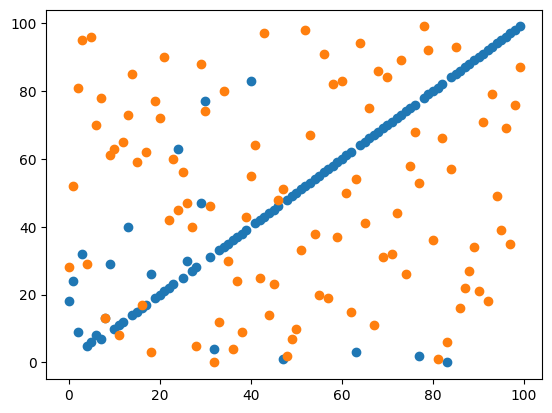

In [227]:
PI = esti_PI_history[13]
esti_PI_order = []
true_PI_order = []
idx = []
for ii in range(n):
    esti_idx = np.where(PI[ii]==1)[0]
    if esti_idx.size > 0:
        esti_idx = esti_idx[0]
    true_idx = np.where(true_PI[ii]==1)[0][0]
    idx.append(ii)
    esti_PI_order.append(esti_idx)
    true_PI_order.append(true_idx)
plt.scatter(idx, esti_PI_order)
plt.scatter(idx, true_PI_order)

In [5]:
###########################################
#        Main Part of ACCA algorithm      #
#               85% reorder               #
###########################################
import random
import numpy as np

### load in the dataset
X = np.loadtxt('Wiki_embeddings/wiki_dw128.txt', delimiter = ' ', \
               skiprows = 1, usecols=range(1, 129)).T
Y_origin = np.loadtxt('Wiki_embeddings/wiki_dw128.txt', delimiter = ' ', \
               skiprows = 1, usecols=range(1, 129)).T

''' reorder 85% of Y dataset '''

### Calculate the number of elements to reorder (10% of the Y dataset)
num_elements_reorder = int(0.85 * Y_origin.shape[1])
### Generate a permutation for the first 10% of the indices
reorder = np.array(random.sample(range(num_elements_reorder), num_elements_reorder))
### create array for the remaining 90% of indices
remaining_indices = np.array(range(num_elements_reorder, Y_origin.shape[1]))
### concatenate the reordered indices with the remaining indices
new_order = np.concatenate((reorder, remaining_indices))
### Apply the new order (reorder 10% of the Y dataset)
Y = Y_origin[:, new_order]
print(Y)

### generate the true permutatoin
true_PI = np.zeros((2405, 2405))
for i in range(2405):
    true_PI[i][new_order[i]]= 1


eval_true_PI = []
for i in range(2405):
    true_idx = np.where(true_PI[i]==1)[0][0]
    eval_true_PI.append(true_idx)
eval_true_PI = np.array(eval_true_PI)
print(range(2045))
print(eval_true_PI)
print("##########################")


from heapq import nlargest
import time
import copy
from procrustes import permutation

# the total training iterations
n = 2405
train_epoch = 3
latent_dims = 96

esti_PI_history = []
acc_history = []
for i in range(train_epoch):
    ## estimate the permutation matrix
    t_PI = time.time()
    if i > 0:
        XU = np.dot(X.T, U)
        YV = np.dot(Y.T, V)
        
        esti_PI = permutation(YV.T, S.T)
        ### Compute the distance betwwen YV and S    
        distance = np.linalg.norm(YV - S, ord='fro')
        print("Distance between YV and S:", distance)
           
        esti_PI = np.array(esti_PI.t)
    else:
        # initialize the PI at totally random
        esti_PI = np.zeros((n, n))
        for j in range(int(n)):
            esti_PI[j] = np.random.dirichlet(np.ones(n),size=1)[0]
    t_PI = time.time() - t_PI
    esti_PI_history.append(esti_PI)
    
    ## estimation of the CCA part
    t_CCA = time.time()
    U, V, S = MAXVAR_MCCA(X, Y, esti_PI)
    print("size of U: \n", U.shape)
    print("size of V: \n", V.shape)
    print("size of P: \n", esti_PI.shape)
    print("size of S: \n", S.shape)
    t_CCA = time.time() - t_CCA
    
    ### evaluate the permutation matrix
    PI = esti_PI_history[i]
    acc = 0.0
    for ii in range(2405):
        esti_idx = np.where(PI[ii]==1)[0]
        if esti_idx.size > 0:
            esti_idx = esti_idx[0]
        true_idx = np.where(true_PI[ii]==1)[0][0]
        print("# evaluate-", ii, " : ", esti_idx, " - ", true_idx, " ...")
        if esti_idx == true_idx:
            acc += 1
    print("# Accuracy of iter = ", i, " is: ", acc/2405)
    acc_history.append(acc)


[[ 0.6147216  -0.5278123   0.02577642 ...  0.16052672 -0.3802807
  -1.4412411 ]
 [ 0.3239713  -0.51885843 -0.18592513 ... -0.10390278 -0.00780051
  -1.0345765 ]
 [ 0.01684656  0.00805387 -0.1638454  ...  0.01883434 -0.21594402
   2.477454  ]
 ...
 [ 0.08414989  0.02374707 -0.19516824 ...  0.18578124 -0.15014867
   0.59148103]
 [-0.29592893  0.13748601 -0.1354599  ... -0.10484107  0.18645848
   0.18861721]
 [-0.14505541 -0.19047035 -0.09536276 ...  0.14075616  0.04773289
  -0.14440607]]
range(0, 2045)
[ 650 1850   55 ... 2402 2403 2404]
##########################
size of U: 
 (128, 160)
size of V: 
 (128, 160)
size of P: 
 (2405, 2405)
size of S: 
 (160, 2405)
# evaluate- 0  :  []  -  650  ...
# evaluate- 1  :  []  -  1850  ...
# evaluate- 2  :  []  -  55  ...
# evaluate- 3  :  []  -  289  ...
# evaluate- 4  :  []  -  1003  ...
# evaluate- 5  :  []  -  271  ...
# evaluate- 6  :  []  -  679  ...
# evaluate- 7  :  []  -  372  ...
# evaluate- 8  :  []  -  1620  ...
# evaluate- 9  :  []  - 

/var/folders/40/dwwt9ypj3bq7hk3cgxb8rkmr0000gn/T/ipykernel_25489/888205011.py:95: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if esti_idx == true_idx:


ValueError: operands could not be broadcast together with shapes (2405,160) (160,2405) 

In [17]:
###########################################
#        Main Part of ACCA algorithm      #
#               50% reorder               #
###########################################
import random

### load in the dataset
X = np.loadtxt('Wiki_embeddings/wiki_dw128.txt', delimiter = ' ', \
               skiprows = 1, usecols=range(1, 129)).T
Y_origin = np.loadtxt('Wiki_embeddings/wiki_hope200.txt', delimiter = ' ', \
               skiprows = 1, usecols=range(1, 201)).T

''' reorder 50% of Y dataset '''

### Calculate the number of elements to reorder (10% of the Y dataset)
num_elements_reorder = int(0.5 * Y_origin.shape[1])
### Generate a permutation for the first 10% of the indices
reorder = np.array(random.sample(range(num_elements_reorder), num_elements_reorder))
### create array for the remaining 90% of indices
remaining_indices = np.array(range(num_elements_reorder, Y_origin.shape[1]))
### concatenate the reordered indices with the remaining indices
new_order = np.concatenate((reorder, remaining_indices))
### Apply the new order (reorder 10% of the Y dataset)
Y = Y_origin[:, new_order]
print("Size of Y: \n", Y.shape)

''' Trim Y dataset as same size as X dataset'''
# If X has fewer or the same number of columns as Y
Y_trim = Y[:X.shape[0],:]
print("size of Y_trim: \n", Y_trim.shape)
print("size of X (for comparing Y_trim): \n", X.shape)
# If X has more columns than Y --- Separate case

### generate the true permutatoin
true_PI = np.zeros((2405, 2405))
for i in range(2405):
    true_PI[i][new_order[i]]= 1


eval_true_PI = []
for i in range(2405):
    true_idx = np.where(true_PI[i]==1)[0][0]
    eval_true_PI.append(true_idx)
eval_true_PI = np.array(eval_true_PI)
# print(range(2045))
print("True PI:", eval_true_PI)
print("##########################")


from heapq import nlargest
import time
import copy
from procrustes import permutation

# the total training iterations
n = 2405
train_epoch = 10
latent_dims = 14

esti_PI_history = []
acc_history = []
for i in range(train_epoch):
    ## estimate the permutation matrix
    t_PI = time.time()
    if i > 0:
        XU = np.dot(X.T, U)
        YV = np.dot(Y.T, V)
        
        esti_PI = permutation(YV.T, S.T)
        ### Compute the distance betwwen YV and S    
        distance = np.linalg.norm(YV - S, ord='fro')
        print("Distance between YV and S:", distance)
        
        esti_PI = np.array(esti_PI.t)
    else:
        # # initialize the PI at totally random
        # esti_PI = np.zeros((n, n))
        # for j in range(int(n)):
        #     esti_PI[j] = np.random.dirichlet(np.ones(n),size=1)[0]
        esti_PI = permutation(X, Y_trim)
        esti_PI = np.array(esti_PI.t)
        # esti_PI = true_PI
    t_PI = time.time() - t_PI
    esti_PI_history.append(esti_PI)
    
    ## estimation of the CCA part
    t_CCA = time.time()
    U, V, S = MAXVAR_MCCA(X, Y, esti_PI)
    t_CCA = time.time() - t_CCA
    
    ### evaluate the permutation matrix
    PI = esti_PI_history[i]
    print("Esimated Pi: \n",PI)
    print("# count of non-zeros in Estimated Pi: ", np.count_nonzero(PI))
    acc = 0.0
    for ii in range(2405):
        esti_idx = np.where(PI[ii]==1)[0]
        if esti_idx.size > 0:
            esti_idx = esti_idx[0]
        true_idx = np.where(true_PI[ii]==1)[0][0]
        print("# evaluate-", ii, " : ", esti_idx, " - ", true_idx, " ...")
        if esti_idx == true_idx:
            acc += 1
    print("# Accuracy of iter = ", i, " is: ", acc/2405)
    acc_history.append(acc)

Size of Y: 
 (200, 2405)
size of Y_trim: 
 (128, 2405)
size of X (for comparing Y_trim): 
 (128, 2405)
True PI: [  68  140  569 ... 2402 2403 2404]
##########################
Esimated Pi: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
# count of non-zeros in Estimated Pi:  2405
# evaluate- 0  :  2372  -  68  ...
# evaluate- 1  :  1481  -  140  ...
# evaluate- 2  :  1634  -  569  ...
# evaluate- 3  :  1349  -  513  ...
# evaluate- 4  :  1752  -  8  ...
# evaluate- 5  :  2345  -  809  ...
# evaluate- 6  :  264  -  69  ...
# evaluate- 7  :  2022  -  662  ...
# evaluate- 8  :  2167  -  1083  ...
# evaluate- 9  :  2233  -  1134  ...
# evaluate- 10  :  1434  -  818  ...
# evaluate- 11  :  1254  -  1188  ...
# evaluate- 12  :  1217  -  904  ...
# evaluate- 13  :  1165  -  871  ...
# evaluate- 14  :  514  -  534  ...
# evaluate- 15  :  2320  -  37  ...
# evaluate- 16  :  1300  -  914 

In [26]:
###########################################
#        Main Part of ACCA algorithm      #
#               100% reorder              #
###########################################
import random

### load in the dataset
X = np.loadtxt('Wiki_embeddings/wiki_dw128.txt', delimiter = ' ', \
               skiprows = 1, usecols=range(1, 129)).T
Y_origin = np.loadtxt('Wiki_embeddings/wiki_hope200.txt', delimiter = ' ', \
               skiprows = 1, usecols=range(1, 201)).T

### reorder the Y dataset randomly
reorder = np.array(random.sample(range(2405), 2405))
Y = Y_origin[:, reorder]
print("Size of Y: \n", Y.shape)

''' Trim Y dataset as same size as X dataset'''
# If X has fewer or the same number of columns as Y
Y_trim = Y[:X.shape[0],:]
print("size of Y_trim: \n", Y_trim.shape)
print("size of X (for comparing Y_trim): \n", X.shape)
# If X has more columns than Y --- Separate case

### generate the true permutatoin
true_PI = np.zeros((2405, 2405))
for i in range(2405):
    true_PI[i][reorder[i]]= 1


eval_true_PI = []
for i in range(2405):
    true_idx = np.where(true_PI[i]==1)[0][0]
    eval_true_PI.append(true_idx)
eval_true_PI = np.array(eval_true_PI)
print(range(2045))
print(eval_true_PI)
print("##########################")


from heapq import nlargest
import time
import copy
from procrustes import permutation

# the total training iterations
n = 2405
train_epoch = 10
latent_dims = 8

esti_PI_history = []
acc_history = []
dis = []
for i in range(train_epoch):
    ## estimate the permutation matrix
    t_PI = time.time()
    if i > 0:
        XU = np.dot(X.T, U)
        YV = np.dot(Y.T, V)
        
        esti_PI = permutation(YV.T, S.T)
        
        ### Compute the distance betwwen YV and S    
        distance = np.linalg.norm(YV - S.T, ord='fro')
        print("Distance between YV and S:", distance)
        dis.append(distance)
        
        esti_PI = np.array(esti_PI.t)
    else:
        # initialize the PI at totally random
        esti_PI = np.zeros((n, n))
        for j in range(int(n)):
            esti_PI[j] = np.random.dirichlet(np.ones(n),size=1)[0]
    t_PI = time.time() - t_PI
    esti_PI_history.append(esti_PI)
    
    ## estimation of the CCA part
    t_CCA = time.time()
    U, V, S = MAXVAR_MCCA(X, Y, esti_PI)
    t_CCA = time.time() - t_CCA
    
    ### evaluate the permutation matrix
    PI = esti_PI_history[i]
    acc = 0.0
    for ii in range(2405):
        esti_idx = np.where(PI[ii]==1)[0]
        if esti_idx.size > 0:
            esti_idx = esti_idx[0]
        true_idx = np.where(true_PI[ii]==1)[0][0]
        print("# evaluate-", ii, " : ", esti_idx, " - ", true_idx, " ...")
        if esti_idx == ii:
            acc += 1
    print("# Accuracy of iter = ", i, " is: ", acc/2405)
    acc_history.append(acc)


Size of Y: 
 (200, 2405)
size of Y_trim: 
 (128, 2405)
size of X (for comparing Y_trim): 
 (128, 2405)
range(0, 2045)
[1332   22  649 ...  568 1370  250]
##########################
# evaluate- 0  :  []  -  1332  ...
# evaluate- 1  :  []  -  22  ...
# evaluate- 2  :  []  -  649  ...
# evaluate- 3  :  []  -  1855  ...
# evaluate- 4  :  []  -  804  ...
# evaluate- 5  :  []  -  941  ...
# evaluate- 6  :  []  -  1350  ...
# evaluate- 7  :  []  -  1645  ...
# evaluate- 8  :  []  -  2291  ...
# evaluate- 9  :  []  -  844  ...
# evaluate- 10  :  []  -  1034  ...
# evaluate- 11  :  []  -  717  ...
# evaluate- 12  :  []  -  1038  ...
# evaluate- 13  :  []  -  1968  ...
# evaluate- 14  :  []  -  1086  ...
# evaluate- 15  :  []  -  1381  ...
# evaluate- 16  :  []  -  1051  ...
# evaluate- 17  :  []  -  692  ...
# evaluate- 18  :  []  -  854  ...
# evaluate- 19  :  []  -  821  ...
# evaluate- 20  :  []  -  595  ...
# evaluate- 21  :  []  -  809  ...
# evaluate- 22  :  []  -  929  ...
# evaluate- 23

/var/folders/40/dwwt9ypj3bq7hk3cgxb8rkmr0000gn/T/ipykernel_51872/715009019.py:91: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if esti_idx == ii:


Distance between YV and S: 329.79933700922123
# evaluate- 0  :  8  -  1332  ...
# evaluate- 1  :  16  -  22  ...
# evaluate- 2  :  15  -  649  ...
# evaluate- 3  :  19  -  1855  ...
# evaluate- 4  :  9  -  804  ...
# evaluate- 5  :  239  -  941  ...
# evaluate- 6  :  10  -  1350  ...
# evaluate- 7  :  13  -  1645  ...
# evaluate- 8  :  14  -  2291  ...
# evaluate- 9  :  11  -  844  ...
# evaluate- 10  :  59  -  1034  ...
# evaluate- 11  :  61  -  717  ...
# evaluate- 12  :  12  -  1038  ...
# evaluate- 13  :  51  -  1968  ...
# evaluate- 14  :  48  -  1086  ...
# evaluate- 15  :  18  -  1381  ...
# evaluate- 16  :  27  -  1051  ...
# evaluate- 17  :  17  -  692  ...
# evaluate- 18  :  42  -  854  ...
# evaluate- 19  :  122  -  821  ...
# evaluate- 20  :  20  -  595  ...
# evaluate- 21  :  21  -  809  ...
# evaluate- 22  :  22  -  929  ...
# evaluate- 23  :  23  -  1487  ...
# evaluate- 24  :  24  -  1552  ...
# evaluate- 25  :  25  -  345  ...
# evaluate- 26  :  26  -  2347  ...
# eval

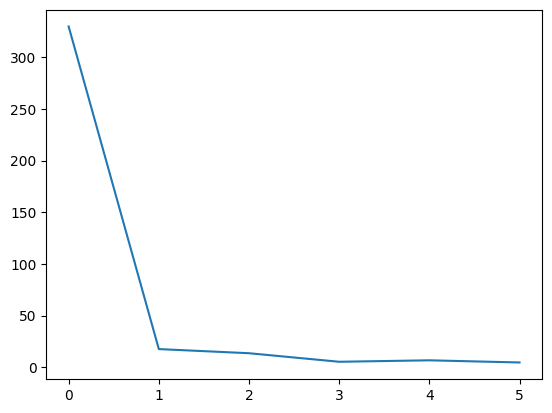

In [28]:
import matplotlib.pyplot as plt
plt.plot(dis[0:6])

In [ ]:
### Compare accuracy with Identity matrix after reordering
for ii in range(2405):
    esti_idx = np.where(esti_PI[ii]==1)[0]
    if esti_idx.size > 0:
        esti_idx = esti_idx[0]
    print("# evaluate-", ii, " : ", esti_idx, " - ", ii, " ...")
    if esti_idx == ii:
        acc += 1
print("# Accuracy of iter = ", i, " is: ", acc/2405)

# evaluate- 0  :  8  -  0  ...
# evaluate- 1  :  75  -  1  ...
# evaluate- 2  :  46  -  2  ...
# evaluate- 3  :  9  -  3  ...
# evaluate- 4  :  27  -  4  ...
# evaluate- 5  :  127  -  5  ...
# evaluate- 6  :  122  -  6  ...
# evaluate- 7  :  32  -  7  ...
# evaluate- 8  :  10  -  8  ...
# evaluate- 9  :  34  -  9  ...
# evaluate- 10  :  12  -  10  ...
# evaluate- 11  :  11  -  11  ...
# evaluate- 12  :  19  -  12  ...
# evaluate- 13  :  13  -  13  ...
# evaluate- 14  :  14  -  14  ...
# evaluate- 15  :  15  -  15  ...
# evaluate- 16  :  16  -  16  ...
# evaluate- 17  :  17  -  17  ...
# evaluate- 18  :  18  -  18  ...
# evaluate- 19  :  82  -  19  ...
# evaluate- 20  :  20  -  20  ...
# evaluate- 21  :  21  -  21  ...
# evaluate- 22  :  22  -  22  ...
# evaluate- 23  :  23  -  23  ...
# evaluate- 24  :  24  -  24  ...
# evaluate- 25  :  25  -  25  ...
# evaluate- 26  :  26  -  26  ...
# evaluate- 27  :  38  -  27  ...
# evaluate- 28  :  28  -  28  ...
# evaluate- 29  :  29  -  29  ...
